In [1]:
import pandas as pd
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

2024-03-24 00:12:08.976753: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-24 00:12:08.976859: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-24 00:12:09.116595: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
test_data_dir = '/kaggle/input/bttai-nybg-2024/BTTAIxNYBG-test.csv'
train_data_dir = '/kaggle/input/bttai-nybg-2024/BTTAIxNYBG-train.csv'
val_data_dir = '/kaggle/input/bttai-nybg-2024/BTTAIxNYBG-validation.csv'

In [3]:
test_img_dir = '/kaggle/input/bttai-nybg-2024/BTTAIxNYBG-test/BTTAIxNYBG-test/'
train_img_dir = '/kaggle/input/bttai-nybg-2024/BTTAIxNYBG-train/BTTAIxNYBG-train/'
val_img_dir = '/kaggle/input/bttai-nybg-2024/BTTAIxNYBG-validation/BTTAIxNYBG-validation/'

In [4]:
df_train = pd.read_csv(train_data_dir)
df_train['imagePath'] = df_train['imageFile'].apply(lambda x: os.path.join(train_img_dir, x))

In [5]:
df_val = pd.read_csv(val_data_dir)
df_val['imagePath'] = df_val['imageFile'].apply(lambda x: os.path.join(val_img_dir, x))

In [6]:
label_encoder = LabelEncoder()
df_train['encoded_labels'] = label_encoder.fit_transform(df_train['classLabel'])

In [7]:
df_train.drop(labels=['uniqueID','source','imageFile'], axis=1, inplace=True)

In [8]:
df_val.drop(labels=['uniqueID','source','imageFile'], axis=1, inplace=True)

In [9]:
df_train.head()

,classLabel,classID,imagePath,encoded_labels
0,occluded-specimens,8,/kaggle/input/bttai-nybg-2024/BTTAIxNYBG-train...,8
1,microscope-slides,6,/kaggle/input/bttai-nybg-2024/BTTAIxNYBG-train...,6
2,illustrations-color,2,/kaggle/input/bttai-nybg-2024/BTTAIxNYBG-train...,2
3,illustrations-color,2,/kaggle/input/bttai-nybg-2024/BTTAIxNYBG-train...,2
4,animal-specimens,0,/kaggle/input/bttai-nybg-2024/BTTAIxNYBG-train...,0


In [10]:
# update for image data generators to try
# train_datagen = ImageDataGenerator(
#     rescale=1./255,
#     rotation_range=20,
#     width_shift_range=0.2,
#     height_shift_range=0.2
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True,
#     fill_mode='nearest'
# )

In [11]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
)
validation_datagen = ImageDataGenerator(
    rescale=1./255,     
)

batch_size = 32 
target_size = 512 # Tried 128, 256, 512

In [12]:
train_generator = train_datagen.flow_from_dataframe(
    df_train,
    x_col='imagePath',
    y_col='classLabel',
    target_size=(target_size, target_size),  # Adjust based on your model requirements
    batch_size=batch_size,
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_dataframe(
    df_val,
    x_col='imagePath',
    y_col='classLabel',
    target_size=(target_size, target_size),  # Adjust based on your model requirements
    batch_size=batch_size,
    class_mode='categorical'
)

Found 81946 validated image filenames belonging to 10 classes.
Found 10244 validated image filenames belonging to 10 classes.


In [13]:
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(target_size, target_size, 3))
base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.2),
    layers.BatchNormalization(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.1),
    layers.BatchNormalization(),
    layers.Dense(len(label_encoder.classes_), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


87910968/87910968 [==============================] - 3s 0us/step


In [14]:
# Fine-tuning to test
# base_model.trainable = True
# fine_tune_at = len(base_model.layers) // 2
# for layer in base_model.layers[:fine_tune_at]:
#     layer.trainable = False

In [15]:
early_stopping = EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=8, # how many epochs to wait before stopping
    restore_best_weights=True,
)

In [16]:
# Train the model
model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    callbacks=[early_stopping], 
    epochs=29 #tried 2, 5,10, 15,20, 30
)

Epoch 1/29


I0000 00:00:1711239254.040024      68 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2560/2560 [==============================] - 1886s 730ms/step - loss: 0.2566 - accuracy: 0.9138 - val_loss: 0.1241 - val_accuracy: 0.9568
Epoch 2/29
2560/2560 [==============================] - 1351s 528ms/step - loss: 0.1576 - accuracy: 0.9452 - val_loss: 0.1060 - val_accuracy: 0.9628
Epoch 3/29
2560/2560 [==============================] - 1338s 523ms/step - loss: 0.1351 - accuracy: 0.9523 - val_loss: 0.1138 - val_accuracy: 0.9598
Epoch 4/29
2560/2560 [==============================] - 1339s 523ms/step - loss: 0.1172 - accuracy: 0.9581 - val_loss: 0.1049 - val_accuracy: 0.9631
Epoch 5/29
2560/2560 [==============================] - 2412s 942ms/step - loss: 0.1053 - accuracy: 0.9630 - val_loss: 0.0954 - val_accuracy: 0.9662
Epoch 6/29
2560/2560 [==============================] - 2130s 832ms/step - loss: 0.0946 - accuracy: 0.9667 - val_loss: 0.0922 - val_accuracy: 0.9671
Epoch 7/29
2560/2560 [==============================] - 1336s 522ms/step - loss: 0.0850 - accuracy: 0.9694 - val_loss

In [17]:
df_test = pd.read_csv(test_data_dir)
df_test['imagePath'] = df_test['imageFile'].apply(lambda x: os.path.join(test_img_dir, x))

In [18]:
df_test.head()

,uniqueID,imageFile,imagePath
0,1,facd4dcd8e869617.jpg,/kaggle/input/bttai-nybg-2024/BTTAIxNYBG-test/...
1,9,78c96bb2b2b62579.jpg,/kaggle/input/bttai-nybg-2024/BTTAIxNYBG-test/...
2,10,d292d2c4e0e6ad9d.jpg,/kaggle/input/bttai-nybg-2024/BTTAIxNYBG-test/...
3,14,3633494929870713.jpg,/kaggle/input/bttai-nybg-2024/BTTAIxNYBG-test/...
4,16,dc94b496c8e2d6c4.jpg,/kaggle/input/bttai-nybg-2024/BTTAIxNYBG-test/...


In [19]:
# Evaluate the model on the test set (assuming the 'test.csv' has 'imageFile' column)
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    df_test,
    x_col='imagePath',
    y_col=None,
    target_size=(target_size, target_size),  # Adjust based on your model requirements
    batch_size=batch_size,
    class_mode=None,
    shuffle=False
)


Found 30690 validated image filenames.


In [20]:
# Predict on the test set
predictions = model.predict(test_generator)

# Decode predictions if needed (convert back to class labels)
predicted_labels = label_encoder.inverse_transform(tf.argmax(predictions, axis=1))

# Print or save the predicted labels as needed
print(predicted_labels)

960/960 [==============================] - 650s 676ms/step
['biocultural-specimens' 'mixed-pressed-specimens' 'live-plants' ...
 'animal-specimens' 'biocultural-specimens' 'illustrations-color']


In [21]:
label_encoder.transform(predicted_labels)

array([1, 7, 4, ..., 0, 1, 2])

In [22]:
df_test['classID'] = label_encoder.transform(predicted_labels)

In [23]:
df_test.head(10)

,uniqueID,imageFile,imagePath,classID
0,1,facd4dcd8e869617.jpg,/kaggle/input/bttai-nybg-2024/BTTAIxNYBG-test/...,1
1,9,78c96bb2b2b62579.jpg,/kaggle/input/bttai-nybg-2024/BTTAIxNYBG-test/...,7
2,10,d292d2c4e0e6ad9d.jpg,/kaggle/input/bttai-nybg-2024/BTTAIxNYBG-test/...,4
3,14,3633494929870713.jpg,/kaggle/input/bttai-nybg-2024/BTTAIxNYBG-test/...,1
4,16,dc94b496c8e2d6c4.jpg,/kaggle/input/bttai-nybg-2024/BTTAIxNYBG-test/...,6
5,24,8e82292b4945cbca.jpg,/kaggle/input/bttai-nybg-2024/BTTAIxNYBG-test/...,1
6,25,65f1c96cf4e064b8.jpg,/kaggle/input/bttai-nybg-2024/BTTAIxNYBG-test/...,4
7,26,e1a4f8f0908de9b9.jpg,/kaggle/input/bttai-nybg-2024/BTTAIxNYBG-test/...,8
8,28,d9594c4ecb435313.jpg,/kaggle/input/bttai-nybg-2024/BTTAIxNYBG-test/...,5
9,34,d44d6996ccc8e26c.jpg,/kaggle/input/bttai-nybg-2024/BTTAIxNYBG-test/...,0


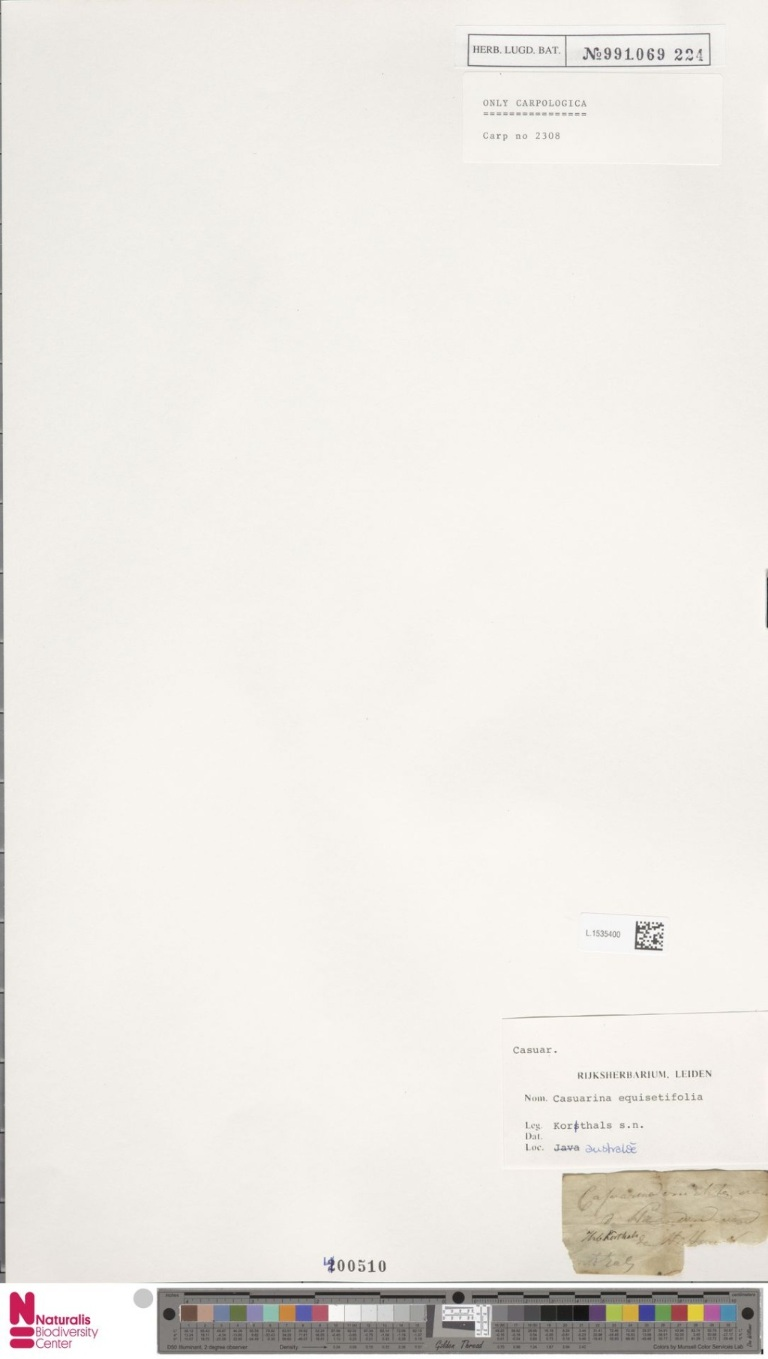

In [24]:
from IPython.display import Image, display
display(Image(filename=df_test.loc[7,'imagePath']))

In [25]:
df_test.drop(labels=['imageFile', 'imagePath'], axis=1, inplace=True)

In [26]:
df_test.to_csv('/kaggle/working/submission.csv', index=False)
print("Submission was sucessfully submitted!")

Submission was sucessfully submitted!
